In [1]:
import numpy as np
#import jax.numpy as jnp

import os
import sys
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *

In [2]:
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_2/Koch_Meinhardt_2.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_2/simulation.txt")
with open(data_path, 'r') as f:
    simulation = eval(f.read())

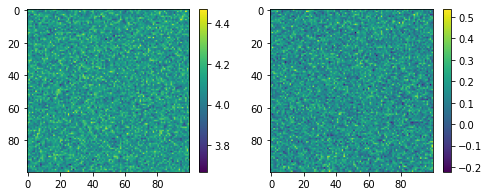

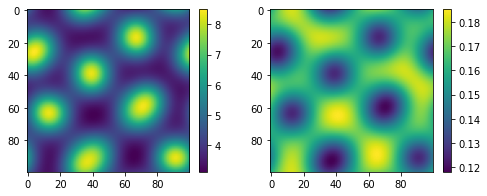

In [3]:
t_star = np.linspace(simulation.t_start, 
                     simulation.t_end, 
                     simulation.t_steps)


T = t_star.shape[0]    

L = simulation.L[0]
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, 0])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, 0])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, -1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, -1])
plt.colorbar(shrink=.75)
plt.show()

In [4]:
dxdy = x_size*y_size/L**2
c_xx =  np.array([[ dxdy  * second_order_derivatives((x_size,y_size), data[c, ..., t])[0] 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_xx = np.einsum("ctij -> cijt", c_xx)
c_yy = np.array([[ dxdy * second_order_derivatives((x_size,y_size), data[c, ..., t])[1] 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_yy = np.einsum("ctij -> cijt", c_yy)

c_t = np.array([[(data[c, ..., t+1] -  data[c, ..., t])/(t_star[t+1] - t_star[t])
                    for t in range(data.shape[3]-1)]
                    for c in range(data.shape[0])
                   ])
c_t = np.einsum("ctij -> cijt", c_t)

In [5]:
t_star = t_star[-2:]
data = data[..., -2:]
c_xx = c_xx[..., -2:]
c_yy = c_yy[..., -2:]
c_t = c_t[..., -2:]
T = t_star.shape[0]  

In [6]:
indices_all = np.arange(0, x_size*y_size*T, 1).reshape((T, x_size,y_size))
#indices_sub = indices_all[:, 30:60, 50:80]
#indices_sub = indices_all[:, 30:65, 50:85]
indices_sub = indices_all[:, 30:65:10, 50:85:10]
block_x = indices_sub.shape[1]
block_y = indices_sub.shape[2]
block_size = indices_sub.shape[1]*indices_sub.shape[2]


model_params = {'training_data_size': x_size*y_size*T,
                'pde_data_size': x_size*y_size*T,
                'boundary_data_size':((x_size + y_size)*T),
                'diffusion': None,
                'derivatives':[c_xx, c_yy, c_t], 
                'signal_to_noise':0.0,
                'shuffle':False,
                'idx_data':indices_sub.flatten()}

dataset = create_dataset(data, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']

obs_inputs = dataset['obs_input']
obs_outputs = dataset['obs_output']
der_u_outputs = dataset["der_u"].T
der_v_outputs = dataset["der_v"].T
obs_X = np.concatenate([obs_inputs, obs_outputs, der_u_outputs, der_v_outputs], axis=1)
pde_X = obs_inputs

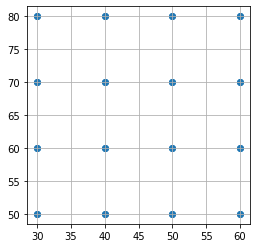

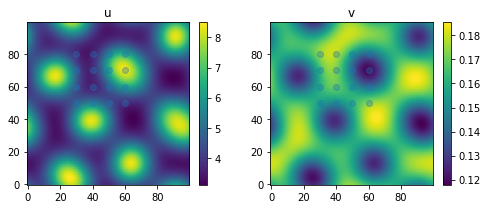

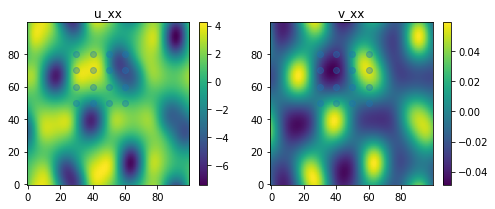

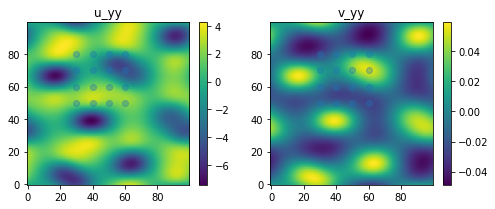

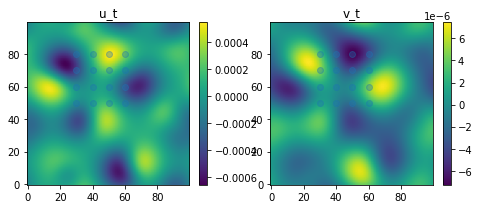

In [7]:
_ = plt.figure(figsize=(4,4))
plt.scatter((x_size-1)*obs_X[:,0]/L, (x_size-1)*obs_X[:,1]/L)
plt.grid()
plt.show()

## Important Note:
##                Since in data the x is the first and y is the second indices,
##                x is changing in the outer arrays. So, we must transpose them on
##                ploting time
def plot_domain(d, title_1="u", title_2="v"):
    _ = plt.figure(figsize=(8,4))
    plt.subplot(121)
    plt.title(f"{title_1}")
    plt.imshow(d[0,:,:, -1].T, origin='lower')
    plt.colorbar(shrink=.75)
    plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.2)
    plt.subplot(122)
    plt.title(f"{title_2}")
    plt.imshow(d[1,:,:, -1].T, origin='lower')
    plt.colorbar(shrink=.75)
    plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.2)    
    plt.show()

plot_domain(data, title_1="u", title_2="v")
plot_domain(c_xx, title_1="u_xx", title_2="v_xx")
plot_domain(c_yy, title_1="u_yy", title_2="v_yy")
plot_domain(c_t, title_1="u_t", title_2="v_t")

In [8]:
def diff_u():
    D_u = simulation.Ds[0] 
    u_xx = der_u_outputs[:, 0]
    u_yy = der_u_outputs[:, 1]
    return D_u * (u_xx + u_yy)

def diff_v():
    D_v = simulation.Ds[1]
    v_xx = der_v_outputs[:, 0]
    v_yy = der_v_outputs[:, 1]
    D_v * (v_xx + v_yy)
    
def interaction_u(kappa_u, rho_u):
    u = obs_outputs[:, 0]
    v = obs_outputs[:, 1]
    f = u * u * v / (1.0 + kappa_u * u * u)
    return rho_u * f

def interaction_v(kappa_u, rho_v):
    u = obs_outputs[:, 0]
    v = obs_outputs[:, 1]
    f = u * u * v / (1.0 + kappa_u * u * u)
    return -rho_v * f

def pde_res_u(kappa_u, rho_u, mu_u, sigma_u):
    D_u = simulation.Ds[0] 
    u = obs_outputs[:, 0]
    v = obs_outputs[:, 1]
    u_xx = der_u_outputs[:, 0]
    u_yy = der_u_outputs[:, 1]
    u_t = der_u_outputs[:, 2]    
    f = u * u * v / (1.0 + kappa_u * u * u)
    return u_t - D_u * (u_xx + u_yy) - rho_u * f + mu_u * u - sigma_u

def pde_res_v(kappa_u, rho_v, sigma_v):
    D_v = simulation.Ds[1]
    u = obs_outputs[:, 0]
    v = obs_outputs[:, 1]
    v_xx = der_v_outputs[:, 0]
    v_yy = der_v_outputs[:, 1]
    v_t = der_v_outputs[:, 2]    
    f = u * u * v / (1.0 + kappa_u * u * u)
    return v_t - D_v * (v_xx + v_yy) + rho_v * f - sigma_v

def create_fast_pde_res_u(kappa_u):    
    D_u = simulation.Ds[0] 
    u = obs_outputs[:, 0]
    v = obs_outputs[:, 1]
    u_xx = der_u_outputs[:, 0]
    u_yy = der_u_outputs[:, 1]
    u_t = der_u_outputs[:, 2]
    f = u * u * v / (1.0 + kappa_u * u * u)
    s = u_t - D_u * (u_xx + u_yy)
    def pde_res_u(rho_u, mu_u, sigma_u):
        return s - rho_u * f + mu_u * u - sigma_u
    return pde_res_u
    
def create_fast_pde_res_v(kappa_u):
    D_v = simulation.Ds[1] 
    u = obs_outputs[:, 0]
    v = obs_outputs[:, 1]
    v_xx = der_v_outputs[:, 0]
    v_yy = der_v_outputs[:, 1]
    v_t = der_v_outputs[:, 2] 
    f = u * u * v / (1.0 + kappa_u * u * u)
    s = v_t - D_v * (v_xx + v_yy)
    def pde_res_v(rho_v, sigma_v):
        return s + rho_v * f - sigma_v
    return pde_res_v
    

def L2_mean(x):
    return np.mean(x**2)

def root_L2_mean(x):
    return np.sqrt(L2_mean(x))

In [9]:
res_u = create_fast_pde_res_u(simulation.parameters['kappa_u'])
res_v = create_fast_pde_res_v(simulation.parameters['kappa_u'])

In [10]:

print(root_L2_mean(
    res_u(simulation.parameters['rho_u'],
          simulation.parameters['mu_u'],
          simulation.parameters['sigma_u'],)
))

print(root_L2_mean(
    res_v(simulation.parameters['rho_v'],
          simulation.parameters['sigma_v'],)
))

1.9116287445683686e-06
2.525774000342432e-08


In [11]:
#kappa_u_r = np.concatenate([[-1, -.5 ], np.linspace(0, 2, 21)]) #n

size = 40

kappa_u_r = np.linspace(-1, 1, size+1)
kappa_u_r_2 = np.linspace(-.05, .05, size+1)
rho_u_r = np.linspace(-2, 2, size+1)
rho_v_r = np.linspace(-.2, .2, size+1)
sigma_u_r = np.linspace(-2, 2, size+1)
sigma_v_r = np.linspace(-.4, .4, size+1)
mu_u_r = np.linspace(-2, 2, size+1)

rho_u_d, mu_u_d, sigma_u_d, kappa_u_1_d = np.meshgrid(rho_u_r, mu_u_r, sigma_u_r, kappa_u_r, indexing='ij')
rho_v_d, sigma_v_d, kappa_u_2_d = np.meshgrid(rho_v_r, sigma_v_r, kappa_u_r_2,  indexing='ij')

In [12]:
kappa_u_1_d.shape

(41, 41, 41, 41)

In [13]:
kappa_u_2_d.shape

(41, 41, 41)

In [14]:
kappa_u_1_d.shape

(41, 41, 41, 41)

In [15]:
rho_u_d.shape

(41, 41, 41, 41)

In [16]:
res_u_per_kappa = [create_fast_pde_res_u(k) for k in kappa_u_r]

In [17]:
res_v_per_kappa = [create_fast_pde_res_v(k) for k in kappa_u_r_2]

In [18]:
u_landscape = np.array([[[[root_L2_mean(f1(r, m , s)) 
               for f1 in res_u_per_kappa]
               for s in sigma_u_r]
               for m in mu_u_r]
               for r in rho_u_r])

In [19]:
u_landscape.shape

(41, 41, 41, 41)

In [20]:
v_landscape = np.array([[[root_L2_mean(f1(r, s)) 
               for f1 in res_v_per_kappa]
               for s in sigma_v_r]
               for r in rho_v_r])

In [21]:
v_landscape.shape

(41, 41, 41)

In [22]:
rho_v_r[25]

0.04999999999999999

In [23]:
def find_index(arr, value, atol=1e-2):
    i = np.argwhere(np.isclose(arr, value, atol=atol) )
    if i.shape[0] > 0:
        return np.argwhere(np.isclose(arr, value, atol=atol) )[0][0]
    else:
        return 0

def find_exact(arr, value, atol=1e-2):
    index = find_index(arr, value, atol)
    return arr[index]


    

In [24]:
(simulation.parameters['rho_v'], 
 find_index(rho_v_r, simulation.parameters['rho_v']),
 find_exact(rho_v_r, simulation.parameters['rho_v'], atol=1e-3)
)

(0.025, 22, -0.2)

In [25]:
def create_plot_u_landscapes(param_1_arr, param_2_arr,
                             param_1_i, param_2_i,
                             param_1_latex, param_2_latex,
                             x_arr, y_arr,
                             x_name, y_name, 
                             x_name_latex, y_name_latex,
                             u_landscape,
                             **kwargs):
    
    def get_slice_u(param_1_index, param_2_index):
        
        return tuple([  slice(param_1_index, 1+param_1_index) if i == param_1_i
                  else slice(param_2_index, 1+param_2_index) if i == param_2_i
                  else slice(0, u_landscape.shape[i])
            for i in range(4) ])
        
        
    def plot_u_landscape(param1, param2):
        param1 = float(param1)
        param2 = float(param2)
        plt.title(param_1_latex + f"={param1:.3f}, "  + param_2_latex + f"={param2:.3f}", fontsize=20)
        param1_index = find_index(param_1_arr, param1, atol=1e-3)
        param2_index = find_index(param_2_arr, param2, atol=1e-3) 
        #plt.contourf(x_arr, y_arr, u_landscape[:, mu_u_index ,:, kappa_u_index])
        s = get_slice_u(param1_index, param2_index)        
        plt.contourf(x_arr, y_arr, u_landscape[s].squeeze())
       
        
        plt.plot([0, x_arr[-1]], [0, 0], c='r')
        plt.plot([0, 0], [0, y_arr[-1]], c='r')
        plt.scatter(simulation.parameters[x_name], simulation.parameters[y_name], marker='x', c='r')
        plt.xlabel(x_name_latex, fontsize=20)
        plt.ylabel(y_name_latex, fontsize=20)
        plt.colorbar()    
        
    return plot_u_landscape

def create_plot_v_landscapes(param_1_arr,
                             param_1_i,
                             param_1_latex,
                             x_arr, y_arr,
                             x_name, y_name, 
                             x_name_latex, y_name_latex,
                             v_landscape,
                             **kwargs):
    def get_slice_v(param_1_index):        
        return tuple([  slice(param_1_index, 1+param_1_index) if i == param_1_i
                  else slice(0, v_landscape.shape[i])
            for i in range(3) ])    

    def plot_v_landscape(param1):
        param1 = float(param1)
        plt.title(param_1_latex + f"={param1:.3f}", fontsize=20)
        param1_index = find_index(param_1_arr, param1, atol=1e-3)
        s = get_slice_v(param1_index)              
        plt.contourf(x_arr, y_arr, v_landscape[s].squeeze())
        
        plt.plot([0, x_arr[-1]], [0, 0], c='r')
        plt.plot([0, 0], [0, y_arr[-1]], c='r')
        plt.scatter(simulation.parameters[x_name], simulation.parameters[y_name], marker='x', c='r')
        plt.xlabel(x_name_latex, fontsize=20)
        plt.ylabel(y_name_latex, fontsize=20)
        plt.colorbar()
        
    return plot_v_landscape

In [26]:
from ipywidgets import interact, Layout#, DescriptionStyle
import ipywidgets as widgets
from ipywidgets.widgets import HBox, VBox, Label
from IPython.display import display

def create_param_SelectionSlider(param_arr, param_name, param_latex):
    return widgets.SelectionSlider(
        options= [f"{v:.3f}" for v in param_arr], # kappa_u_r,
        value=f"{find_exact(param_arr, simulation.parameters[param_name]):.3f}",
        description=param_latex,
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
    )
def creat_tab(spec_u, spec_v, u_landscape, v_landscape):
    plot_u_landscape = create_plot_u_landscapes(u_landscape=u_landscape, **spec_u)
    plot_v_landscape = create_plot_v_landscapes(v_landscape = v_landscape, **spec_v)
    
    param_1_widgets=create_param_SelectionSlider(spec_u.param_1_arr, 
                                                 spec_u.param_1_name, 
                                                 spec_u.param_1_latex)

    param_2_widgets=create_param_SelectionSlider(spec_u.param_2_arr, 
                                                 spec_u.param_2_name, 
                                                 spec_u.param_2_latex)

    param_3_widgets=create_param_SelectionSlider(spec_v.param_1_arr, 
                                                 spec_v.param_1_name, 
                                                 spec_v.param_1_latex)

    reset_button_u = widgets.Button(description='Reset u', disabled=False,)
    def on_clickreset_button_u(w):
        param_1_widgets.value = f"{find_exact(spec_u.param_1_arr,simulation.parameters[spec_u.param_1_name]):.3f}"
        param_2_widgets.value = f"{find_exact(spec_u.param_2_arr,simulation.parameters[spec_u.param_2_name]):.3f}"

    reset_button_v = widgets.Button(description='Reset v', disabled=False,)
    def on_clickreset_button_v(w):
        param_3_widgets.value = f"{find_exact(spec_v.param_1_arr,simulation.parameters[spec_v.param_1_name]):.3f}"

    reset_button_u.on_click(on_clickreset_button_u)
    reset_button_v.on_click(on_clickreset_button_v)

    actuals_widgets = HBox([Label(value=r'$\kappa_u$ = 'f"{simulation.parameters['kappa_u']:.3f}"), 
                            Label(value=r'$\mu_u$ = 'f"{simulation.parameters['mu_u']:.3f}"),
                            Label(value=r'$\rho_u$ = 'f"{simulation.parameters['rho_u']:.3f}"),
                            Label(value=r'$\sigma_u$ = 'f"{simulation.parameters['sigma_u']:.3f}"),
                            Label(value=r'$\rho_v$ = 'f"{simulation.parameters['rho_v']:.3f}"),
                            Label(value=r'$\sigma_v$ = 'f"{simulation.parameters['sigma_v']:.3f}"),
                        ])


    u_plot = widgets.interactive_output(plot_u_landscape, 
                                        {'param1':param_1_widgets, 
                                         'param2':param_2_widgets})
    v_plot = widgets.interactive_output(plot_v_landscape, {'param1':param_3_widgets})



    u_ui = VBox([
        HBox([VBox([param_1_widgets, param_2_widgets]), reset_button_u]),
        HBox([u_plot])
    ])
    v_ui = VBox([
        HBox([VBox([param_3_widgets,VBox([Label(description="")])]), reset_button_v]),
        HBox([v_plot])
    ])

    ui_1 = VBox([
        actuals_widgets,
        HBox([ u_ui, v_ui]),
    ])

    return ui_1
    

In [27]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self


In [28]:



def simulate(kappa_u_1_bound, rho_u_bound, sigma_u_bound, mu_u_bound,
             kappa_u_2_bound, rho_v_bound, sigma_v_bound, size=40):
    
    kappa_u_r = np.linspace(kappa_u_1_bound[0], kappa_u_1_bound[1], size+1)
    kappa_u_r_2 = np.linspace(kappa_u_2_bound[0], kappa_u_2_bound[1], size+1)
    rho_u_r = np.linspace(rho_u_bound[0], rho_u_bound[1], size+1)
    rho_v_r = np.linspace(rho_v_bound[0], rho_v_bound[1], size+1)
    sigma_u_r = np.linspace(sigma_u_bound[0], sigma_u_bound[1], size+1)
    sigma_v_r = np.linspace(sigma_v_bound[0], sigma_v_bound[1], size+1)
    mu_u_r = np.linspace(mu_u_bound[0], mu_u_bound[1], size+1)

    rho_u_d, mu_u_d, sigma_u_d, kappa_u_1_d = np.meshgrid(rho_u_r, mu_u_r, sigma_u_r, kappa_u_r, indexing='ij')
    rho_v_d, sigma_v_d, kappa_u_2_d = np.meshgrid(rho_v_r, sigma_v_r, kappa_u_r_2,  indexing='ij')

    res_u_per_kappa = [create_fast_pde_res_u(k) for k in kappa_u_r]
    res_v_per_kappa = [create_fast_pde_res_v(k) for k in kappa_u_r_2]


    u_landscape = np.array([[[[root_L2_mean(f1(r, m , s)) 
                   for f1 in res_u_per_kappa]
                   for s in sigma_u_r]
                   for m in mu_u_r]
                   for r in rho_u_r])

    v_landscape = np.array([[[root_L2_mean(f1(r, s)) 
                   for f1 in res_v_per_kappa]
                   for s in sigma_v_r]
                   for r in rho_v_r])
    
    combination_u_1 = AttrDict({
        'param_1_arr': kappa_u_r, 
        'param_2_arr': mu_u_r, 
        'param_1_i': 3, 
        'param_2_i': 1, 
        'param_1_name': 'kappa_u',
        'param_2_name': 'mu_u',
        'param_1_latex': r'$\kappa_u$', 
        'param_2_latex': r'$\mu_u$', 
        'x_arr': sigma_u_r, 
        'y_arr': rho_u_r,
        'x_name': 'sigma_u', 
        'y_name': 'rho_u',
        'x_name_latex': r'$\sigma_u$', 
        'y_name_latex': r'$\rho_u$',
    })
    combination_u_2 = AttrDict({
        'param_1_arr': kappa_u_r, 
        'param_2_arr': sigma_u_r, 
        'param_1_i': 3, 
        'param_2_i': 2, 
        'param_1_name': 'kappa_u',
        'param_2_name': 'sigma_u',
        'param_1_latex': r'$\kappa_u$', 
        'param_2_latex': r'$\sigma_u$', 
        'x_arr': mu_u_r, 
        'y_arr': rho_u_r,
        'x_name': 'mu_u', 
        'y_name': 'rho_u',
        'x_name_latex': r'$\mu_u$', 
        'y_name_latex': r'$\rho_u$',
    })

    combination_u_3 = AttrDict({
        'param_1_arr': sigma_u_r, 
        'param_2_arr': mu_u_r, 
        'param_1_i': 2, 
        'param_2_i': 1, 
        'param_1_name': 'sigma_u',
        'param_2_name': 'mu_u',
        'param_1_latex': r'$\sigma_u$', 
        'param_2_latex': r'$\mu_u$', 
        'x_arr': kappa_u_r, 
        'y_arr': rho_u_r,
        'x_name': 'kappa_u', 
        'y_name': 'rho_u',
        'x_name_latex': r'$\kappa_u$', 
        'y_name_latex': r'$\rho_u$',
    })

    combination_v_1 = AttrDict({
        'param_1_arr': kappa_u_r_2,
        'param_1_i': 2,
        'param_1_name': 'kappa_u',
        'param_1_latex': r'$\kappa_u$',
        'x_arr': sigma_v_r, 
        'y_arr': rho_v_r,
        'x_name': 'sigma_v', 
        'y_name': 'rho_v',
        'x_name_latex': r'$\sigma_v$', 
        'y_name_latex': r'$\rho_v$',
    })

    combination_v_2 = AttrDict({
        'param_1_arr': sigma_v_r,
        'param_1_i': 1,
        'param_1_name': 'sigma_v',
        'param_1_latex': r'$\sigma_v$',
        'x_arr': kappa_u_r_2, 
        'y_arr': rho_v_r,
        'x_name': 'kappa_u', 
        'y_name': 'rho_v',
        'x_name_latex': r'$\kappa_u$', 
        'y_name_latex': r'$\rho_v$',
    })

    combination_v_3 = AttrDict({
        'param_1_arr': rho_v_r,
        'param_1_i': 0,
        'param_1_name': 'rho_v',
        'param_1_latex': r'$\rho_v$',
        'x_arr': kappa_u_r_2, 
        'y_arr': sigma_v_r,
        'x_name': 'kappa_u', 
        'y_name': 'sigma_v',
        'x_name_latex': r'$\kappa_u$', 
        'y_name_latex': r'$\sigma_v$',
    })    
    return (combination_u_1, combination_u_2, combination_u_3,
            combination_v_1, combination_v_2, combination_v_3, 
            u_landscape, v_landscape)


In [29]:

def create_range_slider(name):
    return widgets.FloatRangeSlider(value=[-1.0, 1.0], min=-10, max=10.0, step=0.1, description=name,
                                    disabled=False, continuous_update=False, orientation='horizontal',
                                    readout=True, readout_format='.2f',)

kappa_u_1_slider = create_range_slider(r"$\kappa_u$")
sigma_u_slider = create_range_slider(r"$\sigma_u$")
mu_u_slider = create_range_slider(r"$\mu_u$")
rho_u_slider = create_range_slider(r"$\rho_u$")
kappa_u_2_slider = create_range_slider(r"$\kappa_u$")
sigma_v_slider = create_range_slider(r"$\sigma_v$")
rho_v_slider = create_range_slider(r"$\rho_v$")
size_widget = widgets.IntSlider(20, 10, 100, description="size")

def on_click_calculate_button(w):
    calculate_button.disabled = True
    if w.tab is not None:
        w.tab.layout.display = 'none'
        
    (combination_u_1, combination_u_2, combination_u_3,
            combination_v_1, combination_v_2, combination_v_3,
    u_landscape, v_landscape ) = simulate(kappa_u_1_bound=kappa_u_1_slider.value, 
                 rho_u_bound=rho_u_slider.value, 
                 sigma_u_bound=sigma_u_slider.value, 
                 mu_u_bound=mu_u_slider.value,
                 kappa_u_2_bound=kappa_u_2_slider.value, 
                 rho_v_bound=rho_v_slider.value, 
                 sigma_v_bound=sigma_v_slider.value, 
                 size=size_widget.value)
    
    ui_1 = creat_tab(combination_u_1, combination_v_1, u_landscape, v_landscape)
    ui_2 = creat_tab(combination_u_2, combination_v_2, u_landscape, v_landscape)
    ui_3 = creat_tab(combination_u_3, combination_v_3, u_landscape, v_landscape)
    
        
    tab = widgets.Tab()
    tab.children = [ui_1, ui_2, ui_3]
    tab.set_title(0, "rho_u vs sigma_u & rho_u vs sigma_v")
    tab.set_title(1, "rho_u vs mu_u & rho_u vs kappa_u")
    tab.set_title(2, "kappa_u vs rho_u & kappa_u vs sigma_v")
    display(tab)
    w.tab = tab
    calculate_button.disabled = False

calculate_button = widgets.Button(description='Calculate', disabled=False,)
calculate_button.tab = None
calculate_button.on_click(on_click_calculate_button)

ranges = VBox([
    HBox([size_widget]),
    HBox([kappa_u_1_slider, sigma_u_slider, mu_u_slider, rho_u_slider]),
    HBox([kappa_u_2_slider, sigma_v_slider, rho_v_slider]),
    HBox([calculate_button])
    ])

display(ranges)
#on_click_calculate_button(calculate_button)

In [ ]:
tab.layout.disable = True

In [32]:
def plot_u_landscape(kappa_u, mu_u):
    kappa_u = float(kappa_u)
    mu_u = float(mu_u)
    plt.title(r"$\kappa_u$" f"={kappa_u:.2f}, " r"$\mu_u$" f"={mu_u:.2f}", fontsize=20)
    kappa_u_index = find_index(kappa_u_r,kappa_u, atol=1e-3)
    mu_u_index = find_index(mu_u_r, mu_u, atol=1e-3) 
    plt.contourf(sigma_u_r, rho_u_r, u_landscape[:, mu_u_index ,:, kappa_u_index])
    plt.plot([0, sigma_u_r[-1]], [0, 0], c='r')
    plt.plot([0, 0], [0, rho_u_r[-1]], c='r')
    plt.scatter(simulation.parameters['sigma_u'], simulation.parameters['rho_u'], marker='x')
    plt.xlabel(r"$\sigma_u$", fontsize=20)
    plt.ylabel(r"$\rho_u$", fontsize=20)
    plt.colorbar()
    
def plot_v_landscape(kappa_u):
    kappa_u = float(kappa_u)
    plt.title(r"$\kappa_u$" f"={kappa_u:.2f}", fontsize=20)
    kappa_u_index = find_index(kappa_u_r,kappa_u, atol=1e-3)
    plt.contourf(sigma_v_r, rho_v_r, v_landscape[:, :, kappa_u_index])
    plt.plot([0, sigma_v_r[-1]], [0, 0], c='r')
    plt.plot([0, 0], [0, rho_v_r[-1]], c='r')
    plt.scatter(simulation.parameters['sigma_v'], simulation.parameters['rho_v'], marker='x')
    plt.xlabel(r"$\sigma_v$", fontsize=20)
    plt.ylabel(r"$\rho_v$", fontsize=20)
    plt.colorbar()
    


In [33]:


kappa_u_widgets_1= widgets.SelectionSlider(
    options= [f"{v:.2f}" for v in kappa_u_r], # kappa_u_r,
    value=f"{simulation.parameters['kappa_u']:.2f}",
    description=r'$\kappa_u$',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
)

kappa_u_widgets_2= widgets.SelectionSlider(
    options= [f"{v:.2f}" for v in kappa_u_r], # kappa_u_r,
    value=f"{simulation.parameters['kappa_u']:.2f}",
    description=r'$\kappa_u$',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
)

mu_u_widgets= widgets.SelectionSlider(
    options= [f"{v:.2f}" for v in mu_u_r], # kappa_u_r,
    value=f"{find_exact(mu_u_r, simulation.parameters['mu_u']):.2f}",
    description=r'$\mu_u$',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
)

reset_button_u = widgets.Button(description='Reset u', disabled=False,)
def on_clickreset_button_u(w):
    kappa_u_widgets_1.value = f"{simulation.parameters['kappa_u']:.2f}"
    mu_u_widgets.value = f"{find_exact(mu_u_r, simulation.parameters['mu_u']):.2f}"
    
reset_button_v = widgets.Button(description='Reset v', disabled=False,)
def on_clickreset_button_v(w):
    kappa_u_widgets_2.value = f"{simulation.parameters['kappa_u']:.2f}"
    
reset_button_u.on_click(on_clickreset_button_u)
reset_button_v.on_click(on_clickreset_button_v)

actuals_widgets = HBox([Label(value=r'$\kappa_u$ = 'f"{simulation.parameters['kappa_u']:.2f}"), 
                        Label(value=r'$\mu_u$ = 'f"{simulation.parameters['mu_u']:.2f}"),
                        Label(value=r'$\rho_u$ = 'f"{simulation.parameters['rho_u']:.2f}"),
                        Label(value=r'$\sigma_u$ = 'f"{simulation.parameters['sigma_u']:.2f}"),
                    ])


u_plot = widgets.interactive_output(plot_u_landscape, 
                                    {'param1':kappa_u_widgets_1, 
                                     'param2':mu_u_widgets})
v_plot = widgets.interactive_output(plot_v_landscape, {'param3':kappa_u_widgets_2})



u_ui = VBox([
    HBox([VBox([kappa_u_widgets_1, mu_u_widgets]), reset_button_u]),
    HBox([u_plot])
])
v_ui = VBox([
    HBox([VBox([kappa_u_widgets_2,VBox([Label(description="")])]), reset_button_v]),
    HBox([v_plot])
])

ui_1 = HBox([
    u_ui, v_ui
])

tab = widgets.Tab()
tab.children = [ui_1]
tab.set_title(0, "rho_u and sigma_u")

display(tab)

In [ ]:
u_landscape.squeeze

In [34]:
from ipywidgets import interact, Layout#, DescriptionStyle
import ipywidgets as widgets
from ipywidgets.widgets import HBox, VBox, Label
from IPython.display import display

kappa_u_widgets_1= widgets.SelectionSlider(
    options= [f"{v:.3f}" for v in kappa_u_r], # kappa_u_r,
    value=f"{simulation.parameters['kappa_u']:.3f}",
    description=r'$\kappa_u$',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
)

kappa_u_widgets_2= widgets.SelectionSlider(
    options= [f"{v:.3f}" for v in kappa_u_r], # kappa_u_r,
    value=f"{simulation.parameters['kappa_u']:.3f}",
    description=r'$\kappa_u$',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
)

mu_u_widgets= widgets.SelectionSlider(
    options= [f"{v:.3f}" for v in mu_u_r], # kappa_u_r,
    value=f"{find_exact(mu_u_r, simulation.parameters['mu_u']):.3f}",
    description=r'$\mu_u$',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
)

reset_button_u = widgets.Button(description='Reset u', disabled=False,)
def on_clickreset_button_u(w):
    kappa_u_widgets_1.value = f"{simulation.parameters['kappa_u']:.3f}"
    mu_u_widgets.value = f"{find_exact(mu_u_r, simulation.parameters['mu_u']):.3f}"
    
reset_button_v = widgets.Button(description='Reset v', disabled=False,)
def on_clickreset_button_v(w):
    kappa_u_widgets_2.value = f"{simulation.parameters['kappa_u']:.3f}"
    
reset_button_u.on_click(on_clickreset_button_u)
reset_button_v.on_click(on_clickreset_button_v)

actuals_widgets = HBox([Label(value=r'$\kappa_u$ = 'f"{simulation.parameters['kappa_u']:.2f}"), 
                        Label(value=r'$\mu_u$ = 'f"{simulation.parameters['mu_u']:.2f}"),
                        Label(value=r'$\rho_u$ = 'f"{simulation.parameters['rho_u']:.2f}"),
                        Label(value=r'$\sigma_u$ = 'f"{simulation.parameters['sigma_u']:.2f}"),
                    ])


u_plot = widgets.interactive_output(plot_u_landscape, 
                                    {'kappa_u':kappa_u_widgets_1, 
                                     'mu_u':mu_u_widgets})
v_plot = widgets.interactive_output(plot_v_landscape, {'kappa_u':kappa_u_widgets_2})



u_ui = VBox([
    HBox([VBox([kappa_u_widgets_1, mu_u_widgets]), reset_button_u]),
    HBox([u_plot])
])
v_ui = VBox([
    HBox([VBox([kappa_u_widgets_2,VBox([Label(description="")])]), reset_button_v]),
    HBox([v_plot])
])

ui_1 = HBox([
    u_ui, v_ui
])

tab = widgets.Tab()
tab.children = [ui_1]
tab.set_title(0, "U and V")

display(tab)